# Top Tagging exercise 2



## Another approach to the physics problem: jet images

In the previous notebook (TopTagging_1), we have described a very easy approach to tackle a high energy physics problem. In this exercise, we will learn a different approach, that represents the state-of-the-art of a more general problem, that is, image recognition.

We have described what is a jet and how we can reconstruct it, by clustering together the particles produced in the hadronization process of a quark (or a gluon). Let's think about the CMS detector: its shape is basically that of a cylinder. The cylindrical surface of the detector can be unrolled along the radial and the longitudinal coordinates, This surface, that will be a rectangle, can then be divided into "pixels". The particle energy deposits can be converted into "colour intensities" within each pixel. The more dense and the more energetic the particles, the more color density in one particular pixel.

The idea behind jet images is a specific application of the previously described approach: the energy deposits of the jets constituents are transformed into "intensities" of a 2D black and white image. Image recognition algorithms can be therefore applied to a high energy physics problem.

<br>
<img src="https://github.com/laramaktub/imagenes-hep/raw/master/images_jets.png" width="800" >

https://arxiv.org/abs/1612.01551

The images that we are going to use require some pre-processing, such as being properly normalized and oriented. The details are included in the following papers:
* https://arxiv.org/abs/1701.08784
* https://arxiv.org/abs/1803.00107
* https://arxiv.org/abs/1407.5675
* https://arxiv.org/abs/1511.05190

## Image recognition techniques: Convolutional Neural Network

Convolutional neural network (**CNN**) is a class of deep neural networks applied to classify images. A simple CNN is a sequence of layers, and every layer transforms one volume of activations to another through a differentiable function. Two additional types of layers will be used in this exercise, together with the Fully Connected Layer (as in the previous exercise): **Convolutional Layer** and **Pooling Layer**.

### Convolutional layer

Every image can be considered as a matrix of pixel values, describing the color intensity per pixel. (https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)

Let's consider a 5x5 image whose pixel values are only 0 and 1:

<br>
<img src="https://github.com/laramaktub/imagenes-hep/raw/master/matrix1.png" width="150" >

Let's consider another 3x3 matrix, that we will call `filter`:

<br>
<img src="https://github.com/laramaktub/imagenes-hep/raw/master/matrix2.png" width="100" >

The Convolution of the 5x5 image and the 3x3 filter computation can be visualized as follows:

<br>
<img src="https://github.com/laramaktub/imagenes-hep/raw/master/matrix3.gif" width="300" >

We slide the orange matrix over our original image (green) by 1 pixel (also called `stride`). For every position of the filter, we compute element wise multiplication (between the two matrices), and we add the multiplication outputs to get the final integer which forms a single element of the output matrix (pink). Note that the 3×3 matrix "sees" only a part of the input image in each stride.

Once applied to general images, these filters can develop the ability to detect edges, sharpen or blur an image, or even to detect particular objects within a full picture.

A CNN learns the values of these filters (that are our network **weights**) during the training process. The more filters we have, the more image features get extracted and the better our network becomes at recognizing patterns in unseen images.

The size of the Convolved output (or `feature map`) is controlled by three parameters that we must decide before the convolution step is performed:

* `Depth`: depth corresponds to the number of filters we use for the convolution operation. We can think of these three feature maps as stacked 2D matrices.
* `Stride`: stride is the number of pixels by which we slide our filter matrix over the input matrix. When the stride is 1, then we move the filters one pixel at a time. When the stride is 2, then the filters jump 2 pixels at a time as we slide them around. Having a larger stride will produce smaller feature maps.
* `Zero-padding`: sometimes, it is convenient to pad the input matrix with zeros around the border, so that we can apply the filter to bordering elements of our input image matrix. A nice feature of zero padding is that it allows us to control the size of the feature maps.

### Pooling layer

`Pooling` (or downsampling) reduces the dimensionality of each feature map, but it retains the most important information. Pooling can be of different types: Max, Average, Sum.

In case of Max Pooling, we define a spatial neighborhood (for example, a 2×2 window) and take the largest element from the feature map within that window. Instead of taking the largest element we could also take the average (average pooling) or sum of all elements in that window. Max Pooling has been shown to work better.

One can set the pooling stride as well. Pooling makes the input representations (feature dimension) smaller and more manageable, and it reduces the number of parameters and computations in the network, or, in other words, it controls overfitting.


<br>
<img src="https://github.com/laramaktub/imagenes-hep/raw/master/pooling.png" width="500" >




## Understanding the data

In [1]:
import pandas as pd
import keras
import numpy as np
!/opt/conda/bin/python3.6 -m pip install --upgrade tables

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:496: FutureWarn

First, let's have a look at the shape of the input training data. They are stored as pandas **`DataFrame`** HDF5 data (see `pandas` notebook), in the format of `PyTables`. Please note, this time we are using another input dataset.

In [2]:
#This is selecting the full dataset, it will take a while. Comment afterwards!
store_train_full = pd.HDFStore("/home/jovyan/share/TopTaggingData/train_img.h5")


Opening /home/jovyan/share/TopTaggingData/train_img.h5 in read-only mode


This time, we have converted the information of the energy of the jet constituents into an image. Each image has 40x40 pixels = 1600 pixels. Each column represents the *colour* intensity in each pixel.

Let's define a function, `to_image`, that rewrites these columns as a 40x40 numpy matrix, with one additional index, that represents the colours of the image (see later boxes).

In [3]:
# 1 image has 40x40 pixels = 1600 pixels
pixels = ["img_{0}".format(i) for i in range(1600)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,40,40), axis=-1)

Let's now read only the first 10 k events that will be used for training (you can increase this number later):

In [4]:
# Read the first 10k events
df_train = store_train_full.select("table", stop=10000)
images_train = to_image(df_train)

One useful hint: keep the last events of the training set as test samples to evaluate performances. In order to do so, you can use **`stop`** and **`start`** options in **`select`**. Let's prepare a test sample.

In [5]:
# Keep the last 2 k events as test sample
df_test = store_train_full.select("table",start= 1200000 - 2000)
images_test = to_image(df_test)

Let's have a look at the shape of the input training data:


In [6]:
images_train.shape

(10000, 40, 40, 1)

As stated before, this time we have a more complex input shape, a multidimensional matrix with four indices:

* The first index is the number of training events
* The second index labels the pixels of the images (40) along the horizontal axis
* The third index labels the pixels of the images (40) along the vertical axis
* The fourth index labels the colours of the images

In modern image recognition architectures, it is very common to decompose an image into three colour layers: red, green and blue. Our jet images have only one colour (they are black and white), since we are converting the momenta of the particles hitting that particular region of the detector as a color intensity.

In [7]:
print(images_train[0][20])
#One non empty column of pixels along the 20th horizontal pixel

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00464314]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.01716927]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


Let's plot the actual jet images. Let's perform an average of all our training sample. This is because, one jet image alone is very sparse (only few non-empty pixels).

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Save all signal events in one DataFrame
df_signal = df_train[df_train["is_signal_new"]==1]
# Save all background events in one DataFrame
df_background = df_train[df_train["is_signal_new"]==0]

#Perform an average of signal and background DataFrame
df_signal_sum = df_signal.sum(axis = 0, skipna = True)/len(df_signal.index)
df_background_sum = df_background.sum(axis = 0, skipna = True)/len(df_background.index)

#Define an easier function to convert the averaged images into 40x40 matrices
def to_image_plot(df):
    return  df[pixels].values.reshape(40,40)

image_signal = to_image_plot(df_signal_sum)
image_background = to_image_plot(df_background_sum)

In [9]:
print(df_signal.iloc[1])

img_0              0.000000
img_1              0.000000
img_2              0.000000
img_3              0.000000
img_4              0.000000
                    ...    
img_1597           0.000000
img_1598           0.000000
img_1599           0.000000
is_signal_new      1.000000
mass             173.079865
Name: 861529, Length: 1602, dtype: float64


In [10]:
df_signal

,img_0,img_1,img_2,img_3,img_4,img_5,img_6,img_7,img_8,img_9,...,img_1592,img_1593,img_1594,img_1595,img_1596,img_1597,img_1598,img_1599,is_signal_new,mass
307373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,178.012375
861529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,173.079865
104935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.938797
233835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,173.340698
298178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,168.874161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,178.565979
258225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,243.290146
723703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,186.746826
167235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,168.488434


Let's plot signal and background images.

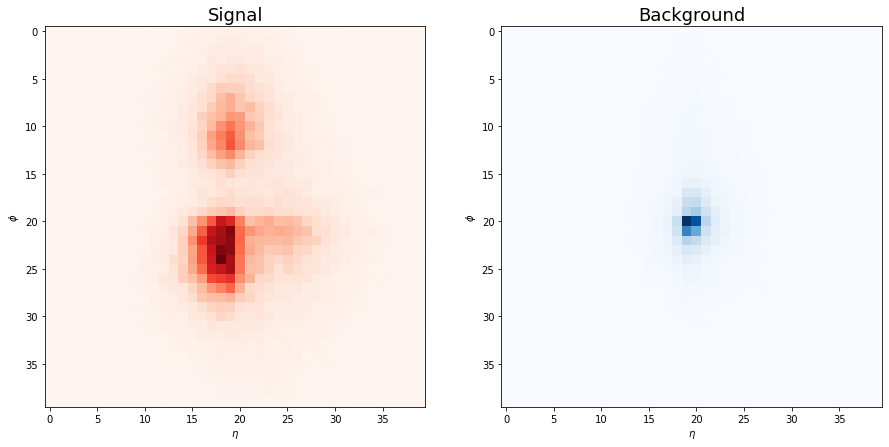

In [11]:
fig, axs = plt.subplots(1, 2,figsize=(15,15))
#plt.subplots_adjust(hspace=0.3)
plt.rcParams.update({'font.size': 15}) #Larger font size

axs[0].imshow(image_signal,cmap="Reds")
axs[0].set_title('Signal')

axs[1].imshow(image_background,cmap="Blues")
axs[1].set_title('Background')


for ax in axs.flat:
    ax.set(xlabel='$\eta$', ylabel='$\phi$')

    
plt.show()

As expected from our physics problem, jets reconstructing top quark decays show a three-pronged structure, whilst background events initiated by strong interaction show a one-pronged structure.

## Building the architecture

Let's start by defining the last layer, that, as in the first part of the exercise, should have a softmax activation function. A keras **`Dense`** layer accepts only vectors as input, and not matrices. The **`Flatten`** function transforms our 40x40 matrix into one single vector.

https://keras.io/layers/core/#flatten

In [12]:
# Define the network
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(40,40,1)))
model.add(keras.layers.Dense(2, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3202      
Total params: 3,202
Trainable params: 3,202
Non-trainable params: 0
_________________________________________________________________
None


As discussed during the first part of this lab, a very natural choice for loss function and optimizer are, respectively, **`categorical_crossentropy`** and **`adam`**.

In [13]:
# Compile the network
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])

As discussed in the introductory tutorial, we can control **overfitting** with a validation sample.

In [14]:
# Load validation sample, only the first 2k events
# They are 20k in total. Use a larger number afterwards
store_val = pd.HDFStore("/home/jovyan/share/TopTaggingData/val_img.h5")
df_val = store_val.select("table",stop=2000)
images_val = to_image(df_val)

Opening /home/jovyan/share/TopTaggingData/val_img.h5 in read-only mode


We are now ready to train our model. Let's first try with 5 epochs. The `is_signal_new` column contains the truth information, i.e. being signal (`is_signal_new=1`) or background (`is_signal_new=0`). That's what the network is supposed to learn.

In [15]:
# Train the network
histObj = model.fit(images_train, keras.utils.to_categorical(df_train["is_signal_new"]), epochs=5, validation_data=(images_val,keras.utils.to_categorical(df_val["is_signal_new"])))

Train on 10000 samples, validate on 2000 samples
Epoch 1/5
10000/10000 [==============================] - 2s 218us/step - loss: 0.6572 - acc: 0.8082 - val_loss: 0.6270 - val_acc: 0.8320
Epoch 2/5
10000/10000 [==============================] - 2s 219us/step - loss: 0.5976 - acc: 0.8414 - val_loss: 0.5778 - val_acc: 0.8300
Epoch 3/5
10000/10000 [==============================] - 2s 223us/step - loss: 0.5511 - acc: 0.8430 - val_loss: 0.5394 - val_acc: 0.8310
Epoch 4/5
10000/10000 [==============================] - 2s 222us/step - loss: 0.5146 - acc: 0.8438 - val_loss: 0.5095 - val_acc: 0.8285
Epoch 5/5
10000/10000 [==============================] - 2s 221us/step - loss: 0.4857 - acc: 0.8458 - val_loss: 0.4860 - val_acc: 0.8305


Let's now plot the learning curves for training and validation samples.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def plotLearningCurves(*histObjs):
    """This function processes all histories given in the tuple.
    Left losses, right accuracies
    """
    # too many plots
    if len(histObjs)>10: 
        print('Too many objects!')
        return
    # missing names
    for histObj in histObjs:
        if not hasattr(histObj, 'name'): histObj.name='?'
    names=[]
    # loss plot
    plt.figure(figsize=(12,6))
    plt.rcParams.update({'font.size': 15}) #Larger font size
    plt.subplot(1,2,1)
    # loop through arguments
    for histObj in histObjs:
        plt.plot(histObj.history['loss'])
        names.append('train '+histObj.name)
        plt.plot(histObj.history['val_loss'])
        names.append('validation '+histObj.name)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper right')
    

    #accuracy plot
    plt.subplot(1,2,2)
    for histObj in histObjs:
        plt.plot(histObj.history['acc'])
        plt.plot(histObj.history['val_acc'])
    plt.title('model accuracy')
    #plt.ylim(0.5,1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    
    plt.show()
    
    # min, max for loss and acc
    for histObj in histObjs:
        h=histObj.history
        maxIdxTrain = np.argmax(h['acc'])
        maxIdxTest  = np.argmax(h['val_acc'])
        minIdxTrain = np.argmin(h['loss'])
        minIdxTest  = np.argmin(h['val_loss'])
        
        strg='\tTrain: Min loss {:6.3f} at {:3d} --- Max acc {:6.3f} at {:3d} | '+histObj.name
        print(strg.format(h['loss'][minIdxTrain],minIdxTrain,h['acc'][maxIdxTrain],maxIdxTrain))
        strg='\tValidation : Min loss {:6.3f} at {:3d} --- Max acc {:6.3f} at {:3d} | '+histObj.name
        print(strg.format(h['val_loss'][minIdxTest],minIdxTest,h['val_acc'][maxIdxTest],maxIdxTest))
        print(len(strg)*'-')

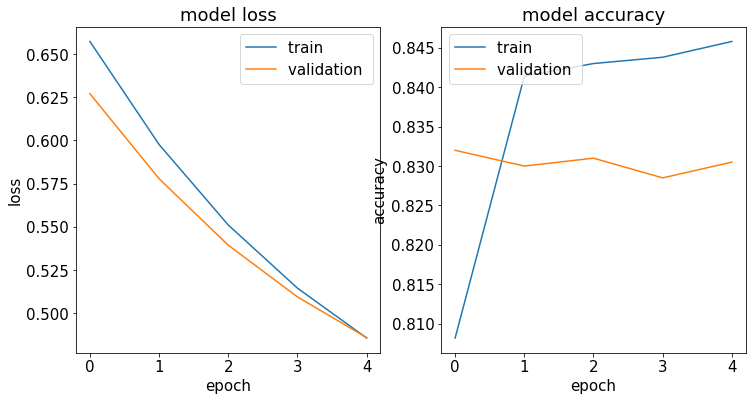

	Train: Min loss  0.486 at   4 --- Max acc  0.846 at   4 | 
	Validation : Min loss  0.486 at   4 --- Max acc  0.832 at   0 | 
-----------------------------------------------------------------------


In [17]:
histObj.name='' # name added to legend
plotLearningCurves(histObj) # the above defined function to plot learning curves

## Evaluating performances




Model evaluation: https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

ROC curves (wikipedia): https://en.wikipedia.org/wiki/Receiver_operating_characteristic

As already explained in TopTagging_1, let's calculate the AUC and the ROC curve.

In [18]:
# Needed libraries
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [19]:
print("Running on test sample. This may take a moment.")
probs = model.predict(images_test)#predict probability over test sample
AUC = roc_auc_score(df_test["is_signal_new"], probs[:,1])
print("Test Area under Curve = {0}".format(AUC))

Running on test sample. This may take a moment.
Test Area under Curve = 0.9058243853948844


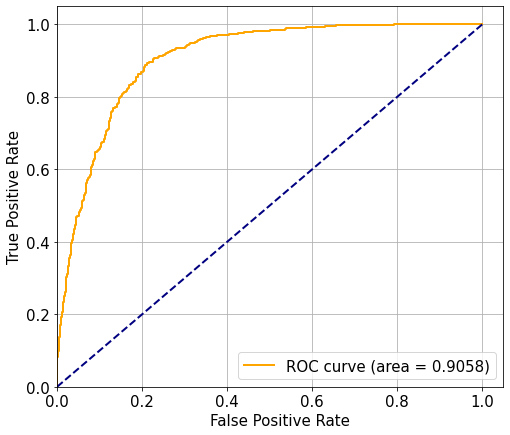

In [20]:
df_test["sigprob"] = probs[:,1] #save probabilities in df
fpr, tpr, _ = roc_curve(df_test["is_signal_new"], df_test["sigprob"]) #extract true positive rate and false positive rate
plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 15}) #Larger font size
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = {0:.4f})'.format(AUC))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

How can these performances be improved?

### Conv2D

Let's try an example with Convolutional Layers, **`Conv2D`**.

Keras documentation on convolutional layers: https://keras.io/layers/convolutional/

Let's have a look at the important parameters we must set:

`keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)`

* `filters`: the dimensionality of the output space (i.e. the number of output filters in the convolution).
* `kernel_size`: 2 integers specifying the height and width of the 2D convolution window (i.e. the dimension of the filters).
* `strides`: 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions.
* `padding`: "same" results in padding the input such that the output has the same length as the original input.
* `activation`: activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
* `Input shape`: when using this layer as the first layer in a model, provide the keyword argument `input_shape` (tuple of integers), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures.

Our `input_shape` will be: `input_shape=(40, 40, 1)` since we have 40x40 black and white pictures.

More advanced options are described in the previous link.

### MaxPooling2D

Another useful layer to use is **`MaxPooling2D`**.

Keras documentation on MaxPooling: https://keras.io/layers/pooling/

Let's have a look at the important parameter we must set:

`keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

* `pool_size`: 2 integers, factors by which to downscale (vertical, horizontal). (2, 2) will halve the input in both spatial dimensions. If only one integer is specified, the same window length will be used for both dimensions.
* `strides`: 2 integers, defining the strides values. If None, it will default to pool_size.
* `padding`: one of "valid" or "same". "valid" means "no padding". 

More advanced options are described in the previous link.

In [21]:
model2 = keras.models.Sequential()

model2.add(keras.layers.Conv2D(8,(4,4),padding='same',input_shape=(40,40,1)))
#Suggestion: add more than 8 filters! Try for example 24, 32, 64...
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(keras.layers.Flatten())
#Sugestion: add a Dense layer, with relu activation here! Try 50, 100, 200 nodes...
model2.add(keras.layers.Dense(2, activation='softmax'))
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 40, 8)         136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6402      
Total params: 6,538
Trainable params: 6,538
Non-trainable params: 0
_________________________________________________________________
None


Let's compile and fit the model. This time the training will take longer, since the model is more complex and it includes more trainable parameters:

In [22]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])

In [23]:
histObj2 = model2.fit(images_train, keras.utils.to_categorical(df_train["is_signal_new"]), epochs=5, validation_data=(images_val,keras.utils.to_categorical(df_val["is_signal_new"])))

Train on 10000 samples, validate on 2000 samples
Epoch 1/5
10000/10000 [==============================] - 7s 748us/step - loss: 0.4729 - acc: 0.8316 - val_loss: 0.3983 - val_acc: 0.8230
Epoch 2/5
10000/10000 [==============================] - 7s 721us/step - loss: 0.3646 - acc: 0.8469 - val_loss: 0.3835 - val_acc: 0.8250
Epoch 3/5
10000/10000 [==============================] - 7s 726us/step - loss: 0.3553 - acc: 0.8489 - val_loss: 0.3744 - val_acc: 0.8350
Epoch 4/5
10000/10000 [==============================] - 7s 711us/step - loss: 0.3506 - acc: 0.8525 - val_loss: 0.3723 - val_acc: 0.8320
Epoch 5/5
10000/10000 [==============================] - 7s 703us/step - loss: 0.3474 - acc: 0.8529 - val_loss: 0.3693 - val_acc: 0.8330


Let's evaluate on the test sample and produce the ROC curve:

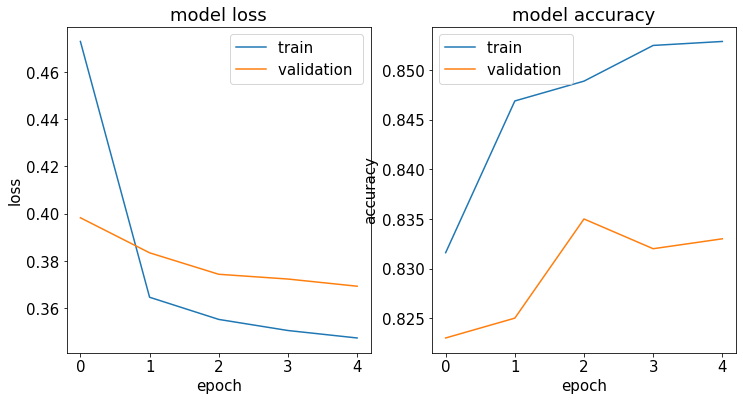

	Train: Min loss  0.347 at   4 --- Max acc  0.853 at   4 | 
	Validation : Min loss  0.369 at   4 --- Max acc  0.835 at   2 | 
-----------------------------------------------------------------------


In [24]:
histObj2.name='' # name added to legend
plotLearningCurves(histObj2) # the above defined function to plot learning curves

In [25]:
print("Running on test sample. This may take a moment.")
probs2 = model2.predict(images_test)#predict probability over test sample
AUC2 = roc_auc_score(df_test["is_signal_new"], probs2[:,1])
print("Test Area under Curve = {0}".format(AUC2))

Running on test sample. This may take a moment.
Test Area under Curve = 0.9190120315895478


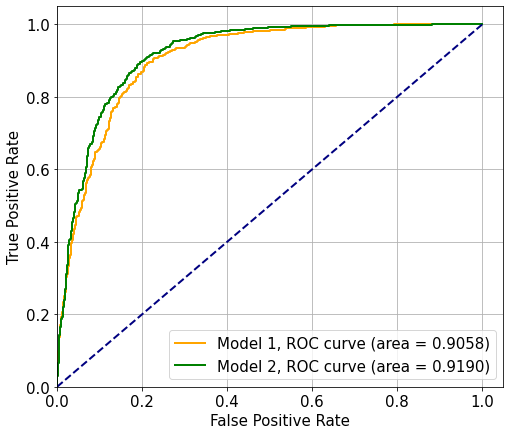

In [26]:
df_test["sigprob"] = probs2[:,1] #save probabilities in df
fpr2, tpr2, _ = roc_curve(df_test["is_signal_new"], df_test["sigprob"]) #extract true positive rate and false positive rate
plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 15}) #Larger font size
plt.plot(fpr, tpr, color='orange', lw=2, label='Model 1, ROC curve (area = {0:.4f})'.format(AUC))
plt.plot(fpr2, tpr2, color='green', lw=2, label='Model 2, ROC curve (area = {0:.4f})'.format(AUC2))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

One can already appreciate a significative improvement. How can we do better?

* Adding more data is always a good idea. But pay attention: if you have a complicated architecture and a lot of data, the training process will slow down.
* Try to use more convolutional layers.
* Try different filter sizes and different numbers of filters on convolutional layers.
* Play around with **`Pooling`** (different size).
* Add more **`Dense`** layers after the convolutional part.
* You can try other ways to prevent overfitting, such as **`Dropout`** or **`early stopping`**? (one **`Dropout`** layer with rate 0.3 can already improve *a lot* the overfitting)

About **`Dropout`**: https://keras.io/layers/core/#dropout

Example:

``model2.add(keras.layers.Dropout(rate=0.3))``

# Challenge submission

Once you manage to improve the network performances, you can submit your results and participate to our ML challenge. The challenge test sample is available in this workspace, but the truth labels (`is_signal_new`) are removed, so that you can't compute the AUC.

* You can participate as a single participant or as a team
* The winner is the one scoring the best AUC in the challenge test sample
* In the next box, you will find some lines of code for preparing an output zip file, containing your model and the weights you obtained out of your training
* Choose a meaningful name for your result zip file (i.e. your name, or your team name, but avoid to submit `results.zip`)
* Download the zip file and send it to me :-)
* You can submit multiple results, paying attention to name them accordingly (add the version number, such as `v1`, `v34`, etc.)
* You can use both TopTagging_1 or TopTagging_2 as a starting point (train over constituents or over images)
* We will consider your best result for the final score
* The winner will be asked to present his architecture

**Have fun!**

In [27]:
### Evaluate performance on independent sample
# DO NOT CHANGE BELOW!f
from IPython.display import FileLink, FileLinks

# Prepare input
store_test_challenge = pd.HDFStore("/home/jovyan/share/TopTaggingData/test_without_truth_img_100k.h5")
#store_test = pandas.HDFStore("test.h5")
df_test_challenge = store_test_challenge.select("table")
images_challenge = to_image(df_test_challenge)

# Run DNN
print("Running on full test sample. This may take a moment.")
ret = model2.predict(images_challenge)
#print(ret[:,1])
np.save("result.npy",ret[:,1])

#Save in zip:
#!zip result.zip result.npy
import zipfile
zipf = zipfile.ZipFile('result.zip', 'w', zipfile.ZIP_DEFLATED)
zipf.write('result.npy')
zipf.close()
print("Done. Click below  to download result")
FileLink('result.zip')

Opening /home/jovyan/share/TopTaggingData/test_without_truth_img_100k.h5 in read-only mode
Running on full test sample. This may take a moment.
Done. Click below  to download result


/home/jovyan/MasterDataScience_TopTagging/result.zip